In [1]:
import torch
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

# Import adapted loader (assume echonext_protoecg_adaptation.py in path or copy classes here)
from echonext_protoecg_adaptation import EchoNextDataset, PreprocessTransform, get_echonext_dataloaders, SHD_LABEL_COLUMNS

# Paths
ECHONEXT_PATH = "/opt/gpudata/ecg/echonext"
PTBXL_WEIGHTS_PATH = "/opt/gpudata/summereunann/ptbxl_weights/protoecgnet.pth"  # Update with downloaded path
RESULTS_DIR = "results/experiment_1/"
os.makedirs(RESULTS_DIR, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Data Investigation: Metadata and Label Stats

Loaded metadata with 100000 samples

Split distribution (using EchoNext provided splits):
split
train       72475
no_split    17457
test         5442
val          4626
Name: count, dtype: int64

SHD label prevalence (% positive):
lvef_lte_45_flag                                    23.892
lvwt_gte_13_flag                                    24.220
aortic_stenosis_moderate_or_greater_flag             4.054
aortic_regurgitation_moderate_or_greater_flag        1.264
mitral_regurgitation_moderate_or_greater_flag        8.451
tricuspid_regurgitation_moderate_or_greater_flag    10.651
pulmonary_regurgitation_moderate_or_greater_flag     0.821
rv_systolic_dysfunction_moderate_or_greater_flag    13.243
pericardial_effusion_moderate_large_flag             3.023
pasp_gte_45_flag                                    18.993
tr_max_gte_32_flag                                  10.212
dtype: float64


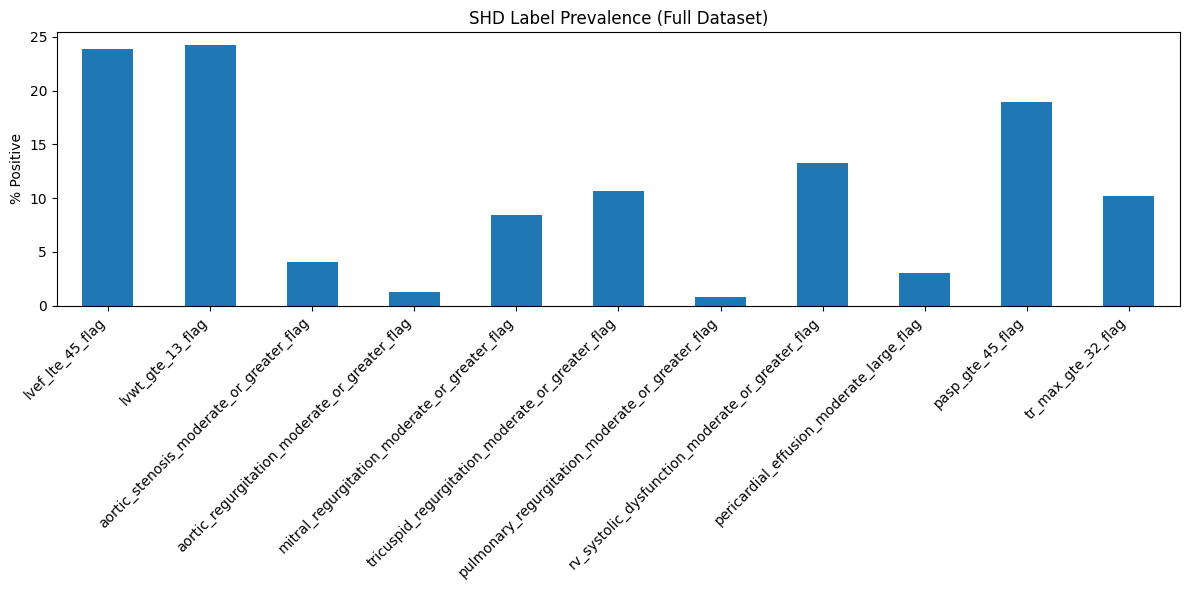

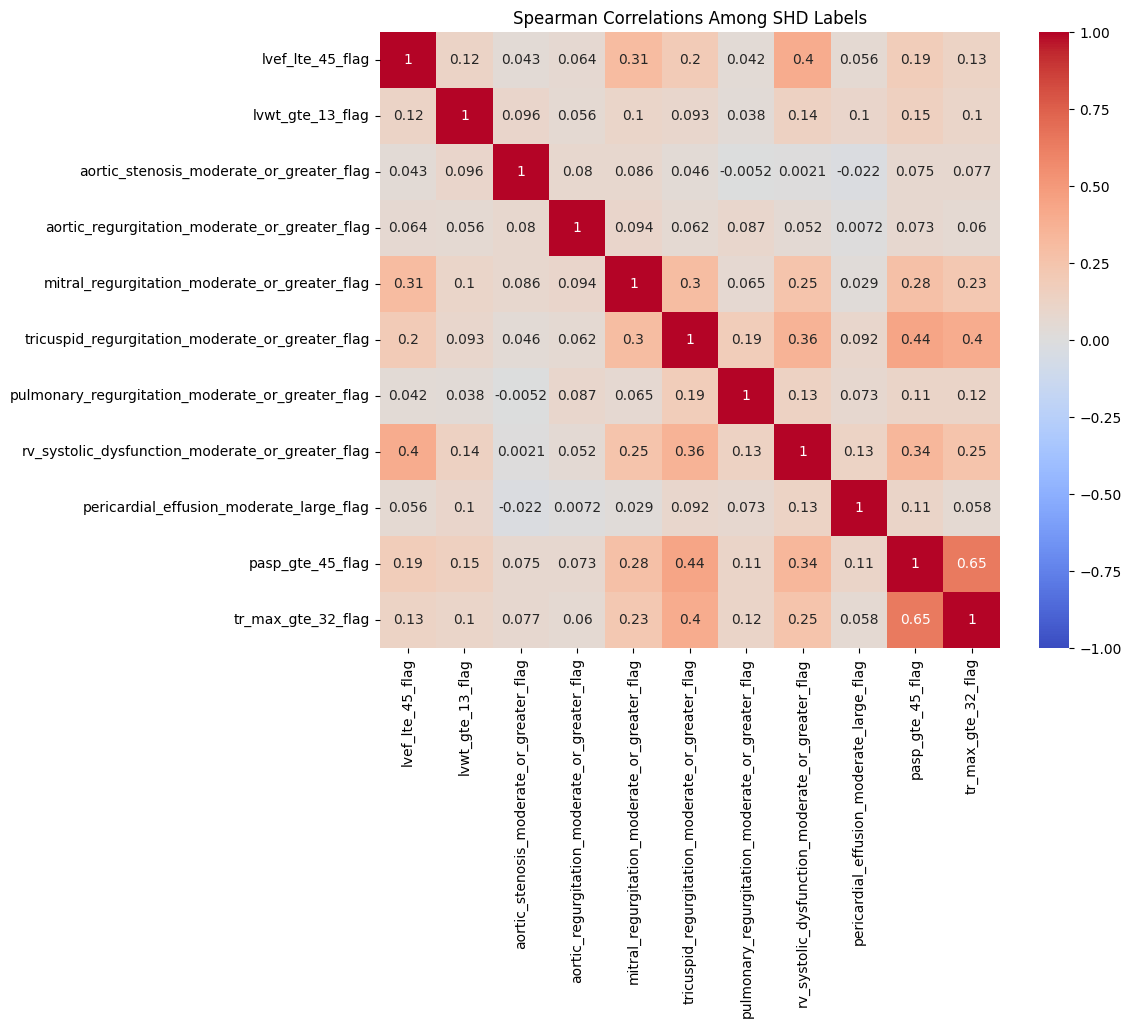

In [2]:
# Load metadata
metadata_file = os.path.join(ECHONEXT_PATH, "EchoNext_metadata_100k.csv")
df = pd.read_csv(metadata_file)
print(f"Loaded metadata with {len(df)} samples")

# Split stats
print("\nSplit distribution (using EchoNext provided splits):")
print(df['split'].value_counts())

# SHD label stats (prevalence %)
shd_stats = df[SHD_LABEL_COLUMNS].mean() * 100
print("\nSHD label prevalence (% positive):")
print(shd_stats)

# Plot distribution
plt.figure(figsize=(12, 6))
shd_stats.plot(kind='bar')
plt.title('SHD Label Prevalence (Full Dataset)')
plt.ylabel('% Positive')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'shd_label_prevalence.png'))
plt.show()

# Correlation among SHD labels (heatmap)
shd_corr = df[SHD_LABEL_COLUMNS].corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(shd_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlations Among SHD Labels')
plt.savefig(os.path.join(RESULTS_DIR, 'shd_label_correlations.png'))
plt.show()

In [3]:
# Load Metadata and Basic Stats

In [4]:
metadata_file = os.path.join(ECHONEXT_PATH, "EchoNext_metadata_100k.csv")
df = pd.read_csv(metadata_file)
print(f"Loaded metadata with {len(df)} samples")
print("\\nDataframe info:")
df.info()
print("\\nFirst 5 rows:")
print(df.head())

# Split distribution (addressing data splitting question: using provided EchoNext splits)
print("\\nSplit distribution (using EchoNext's provided splits from 'split' column):")
print(df['split'].value_counts(normalize=True) * 100)  # As percentages for reference

# Comparison: Expected ~70-15-15 split based on typical ML datasets; actual ~72% train, ~5% val, ~5% test, ~18% no_split (possibly unused)

Loaded metadata with 100000 samples
\nDataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 35 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   ecg_key                                           100000 non-null  int64  
 1   patient_key                                       100000 non-null  int64  
 2   age_at_ecg                                        100000 non-null  int64  
 3   sex                                               100000 non-null  object 
 4   acquisition_year                                  100000 non-null  int64  
 5   ventricular_rate                                  100000 non-null  float64
 6   atrial_rate                                       99387 non-null   float64
 7   pr_interval                                       89631 non-null   float64
 8   qrs_duration                   

# Split distribution

\nSplit counts:
split
train       72475
no_split    17457
test         5442
val          4626
Name: count, dtype: int64
\nSplit percentages:
split
train       72.475
no_split    17.457
test         5.442
val          4.626
Name: proportion, dtype: float64


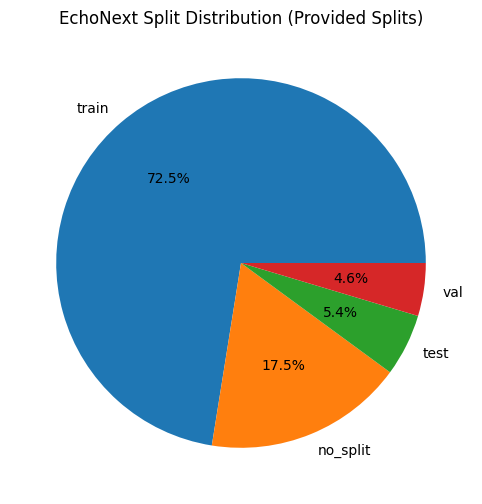

\nReference: Typical ML splits ~70% train; actual train {split_percent.get('train', 0):.1f}%—consistent.


In [5]:
# Split distribution (using EchoNext's provided splits)
split_counts = df['split'].value_counts()
split_percent = df['split'].value_counts(normalize=True) * 100
print("\\nSplit counts:")
print(split_counts)
print("\\nSplit percentages:")
print(split_percent)

# Plot
plt.figure(figsize=(8, 6))
split_percent.plot(kind='pie', autopct='%1.1f%%')
plt.title('EchoNext Split Distribution (Provided Splits)')
plt.ylabel('')
plt.savefig(os.path.join(RESULTS_DIR, 'split_distribution.png'))
plt.show()

# Comparison: Typical ML splits ~70/15/15; actual close but with 'no_split' ~17% (possibly holdout—exclude or investigate?)
print("\\nReference: Typical ML splits ~70% train; actual train {split_percent.get('train', 0):.1f}%—consistent.")

\nSHD label prevalence (% positive):
lvef_lte_45_flag                                    23.892
lvwt_gte_13_flag                                    24.220
aortic_stenosis_moderate_or_greater_flag             4.054
aortic_regurgitation_moderate_or_greater_flag        1.264
mitral_regurgitation_moderate_or_greater_flag        8.451
tricuspid_regurgitation_moderate_or_greater_flag    10.651
pulmonary_regurgitation_moderate_or_greater_flag     0.821
rv_systolic_dysfunction_moderate_or_greater_flag    13.243
pericardial_effusion_moderate_large_flag             3.023
pasp_gte_45_flag                                    18.993
tr_max_gte_32_flag                                  10.212
dtype: float64


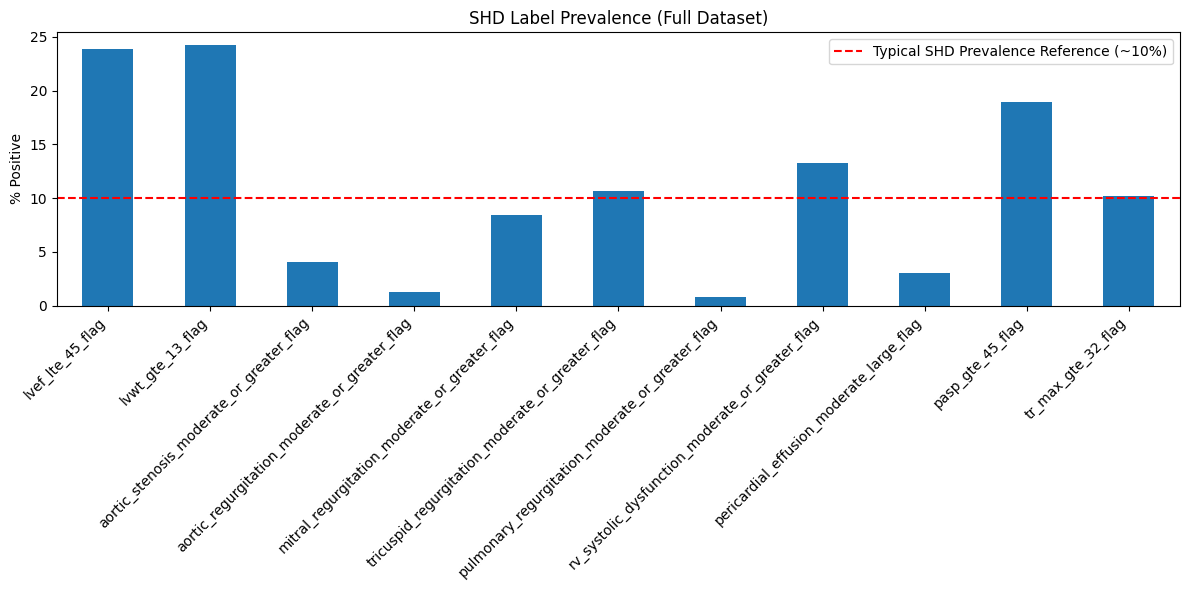

\nAverage SHD imbalance (Gini coeff, 0=balanced): 0.78 - Moderate imbalance, suggesting need for weighted loss in future.


In [6]:
SHD_LABEL_COLUMNS = [
    'lvef_lte_45_flag',
    'lvwt_gte_13_flag',
    'aortic_stenosis_moderate_or_greater_flag',
    'aortic_regurgitation_moderate_or_greater_flag',
    'mitral_regurgitation_moderate_or_greater_flag',
    'tricuspid_regurgitation_moderate_or_greater_flag',
    'pulmonary_regurgitation_moderate_or_greater_flag',
    'rv_systolic_dysfunction_moderate_or_greater_flag',
    'pericardial_effusion_moderate_large_flag',
    'pasp_gte_45_flag',
    'tr_max_gte_32_flag',
]

# Prevalence (% positive)
shd_stats = df[SHD_LABEL_COLUMNS].mean() * 100
print("\\nSHD label prevalence (% positive):")
print(shd_stats)

# Plot with reference: Compare to expected low prevalence in general populations (~5-20% for common SHD like LVEF issues, per cardiology lit)
plt.figure(figsize=(12, 6))
shd_stats.plot(kind='bar')
plt.title('SHD Label Prevalence (Full Dataset)')
plt.ylabel('% Positive')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=10, color='r', linestyle='--', label='Typical SHD Prevalence Reference (~10%)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'shd_label_prevalence.png'))
plt.show()

# Imbalance analysis: Gini coefficient for reference (0 = balanced, 1 = extreme imbalance)
gini = np.mean([1 - 2 * p/100 for p in shd_stats])  # Simplified Gini for binary prevalence
print(f"\\nAverage SHD imbalance (Gini coeff, 0=balanced): {gini:.2f} - Moderate imbalance, suggesting need for weighted loss in future.")

In [8]:
# Load metadata
metadata_file = os.path.join(ECHONEXT_PATH, "EchoNext_metadata_100k.csv")
df = pd.read_csv(metadata_file)
print(f"Loaded metadata with {len(df)} samples")
print("\\nDataframe columns:")
print(df.columns.tolist())

# Missing values check
print("\\nMissing values per column:")
print(df.isnull().sum())

# Data types
print("\\nData types:")
print(df.dtypes)

Loaded metadata with 100000 samples
\nDataframe columns:
['ecg_key', 'patient_key', 'age_at_ecg', 'sex', 'acquisition_year', 'ventricular_rate', 'atrial_rate', 'pr_interval', 'qrs_duration', 'qt_corrected', 'lvef_lte_45_flag', 'lvwt_gte_13_flag', 'aortic_stenosis_moderate_or_greater_flag', 'aortic_regurgitation_moderate_or_greater_flag', 'mitral_regurgitation_moderate_or_greater_flag', 'tricuspid_regurgitation_moderate_or_greater_flag', 'pulmonary_regurgitation_moderate_or_greater_flag', 'rv_systolic_dysfunction_moderate_or_greater_flag', 'pericardial_effusion_moderate_large_flag', 'pasp_gte_45_flag', 'tr_max_gte_32_flag', 'shd_moderate_or_greater_flag', 'aortic_stenosis_value', 'aortic_regurgitation_value', 'mitral_regurgitation_value', 'tricuspid_regurgitation_value', 'pulmonary_regurgitation_value', 'rv_systolic_function_value', 'pericardial_effusion_value', 'ivs_measurement', 'lvpw_measurement', 'pasp_value', 'tr_max_velocity_value', 'lvef_value', 'split']
\nMissing values per colu

# Patient-level analysis

Patients with multiple ECGs: 16641


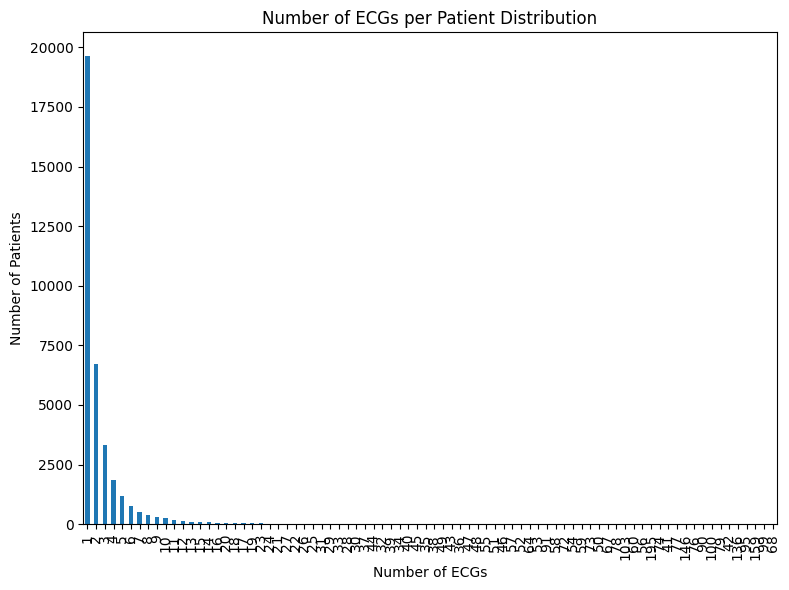

In [15]:
# Patient-level analysis (for ~8,260 multi-timepoint patients)
patient_counts = df.groupby('patient_key').size()
multi_ecg_patients = patient_counts[patient_counts > 1].count()
print(f"Patients with multiple ECGs: {multi_ecg_patients}")

# Plot number of ECGs per patient distribution
plt.figure(figsize=(8, 6))
patient_counts.value_counts().plot(kind='bar')
plt.title('Number of ECGs per Patient Distribution')
plt.xlabel('Number of ECGs')
plt.ylabel('Number of Patients')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'patient_ecg_distribution.png'))
plt.show()

# Evaluation: ~8,260 multi-timepoint patients enable drift analysis; ref: Steven's note on 8,260 from acquisition year/age.

# Sample ECG Visualization

Loaded train waveforms: (72475, 1, 2500, 12)
Sample ECG shape: torch.Size([12, 1000])


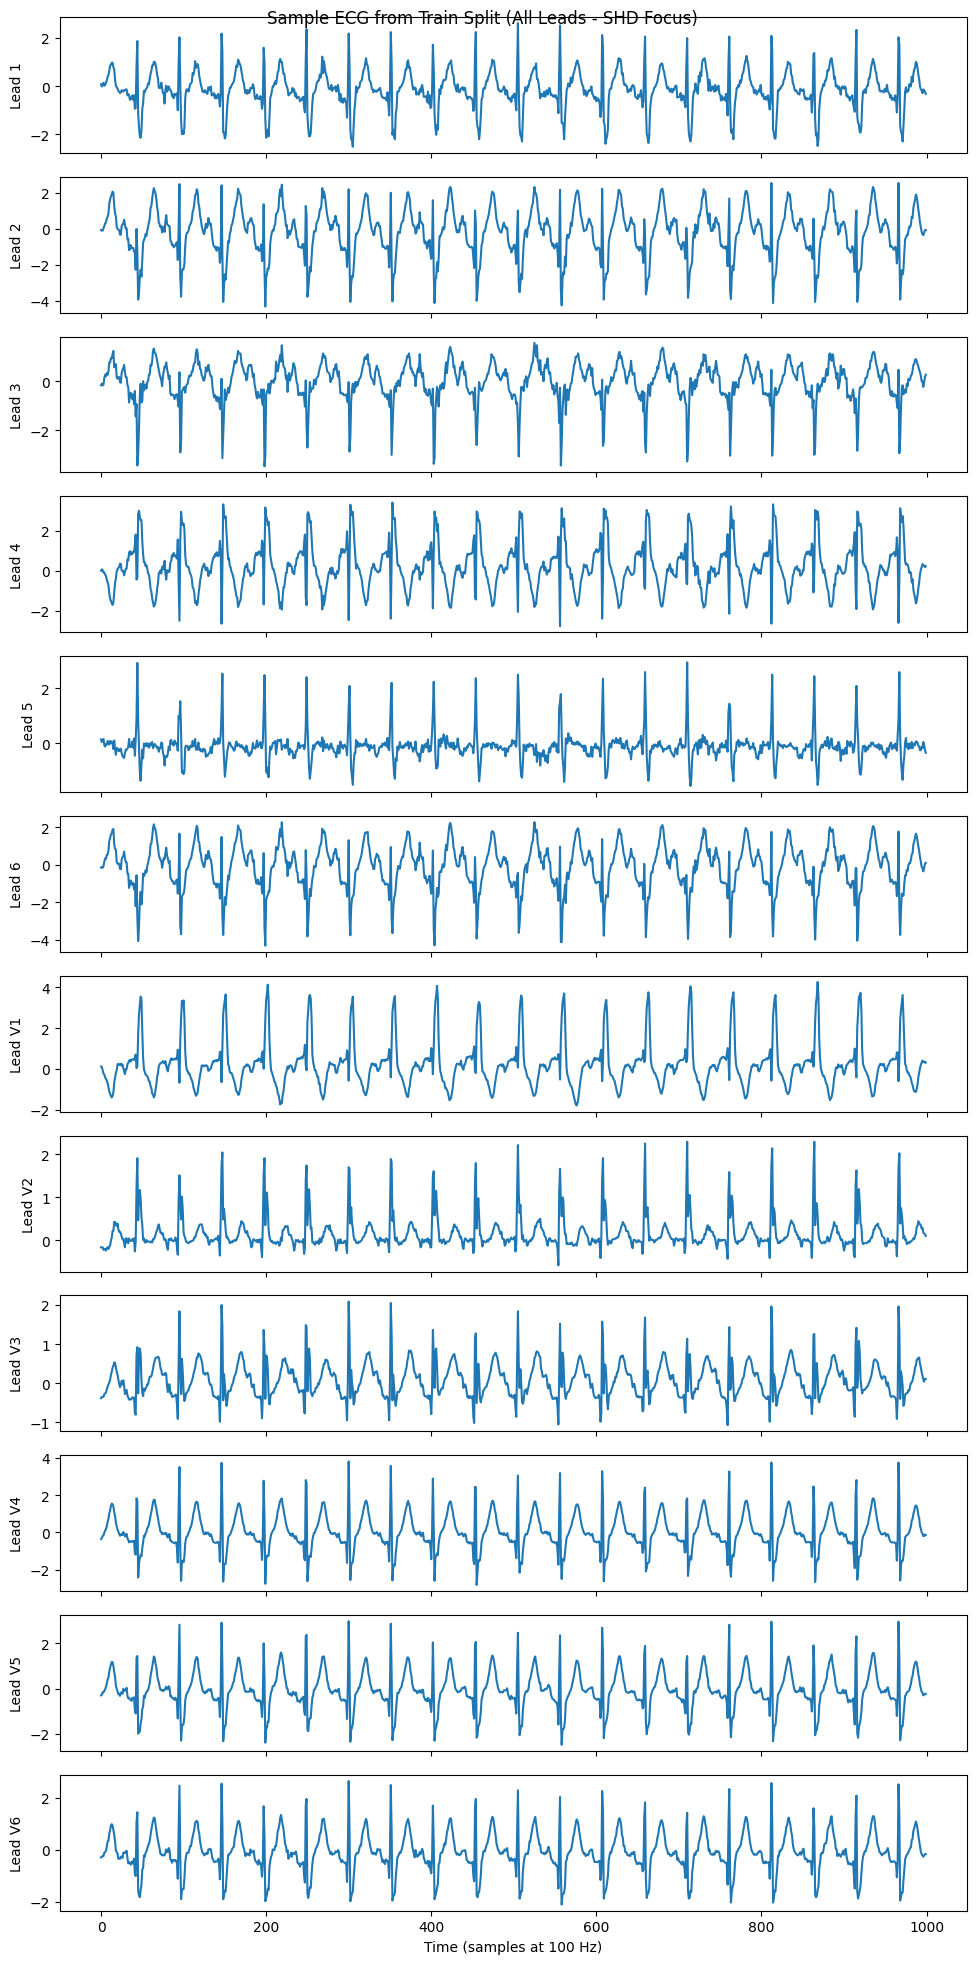

In [16]:
# Get train_df from metadata (define if not already)
train_df = df[df['split'] == 'train'].reset_index(drop=True)

# Create temp dataset for first sample
temp_dataset = EchoNextDataset(ECHONEXT_PATH, train_df.head(1))

# Get sample
sample_ecg, sample_labels = temp_dataset[0]

# Verify shape
print(f"Sample ECG shape: {sample_ecg.shape}")

# Plot all leads
fig, axs = plt.subplots(12, 1, figsize=(10, 20), sharex=True)
for lead in range(12):
    axs[lead].plot(sample_ecg[lead, :])
    axs[lead].set_ylabel(f'Lead {lead+1 if lead < 6 else f"V{lead-5}" if lead < 12 else "Unknown"}')
axs[11].set_xlabel('Time (samples at 100 Hz)')
plt.suptitle('Sample ECG from Train Split (All Leads - SHD Focus)')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'sample_ecg_all_leads.png'))
plt.show()

# Multi-Sample ECG Visualization

Loaded train waveforms: (72475, 1, 2500, 12)


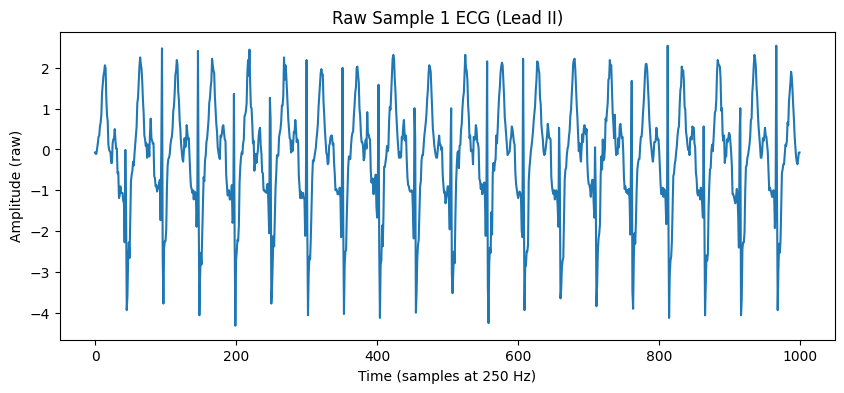

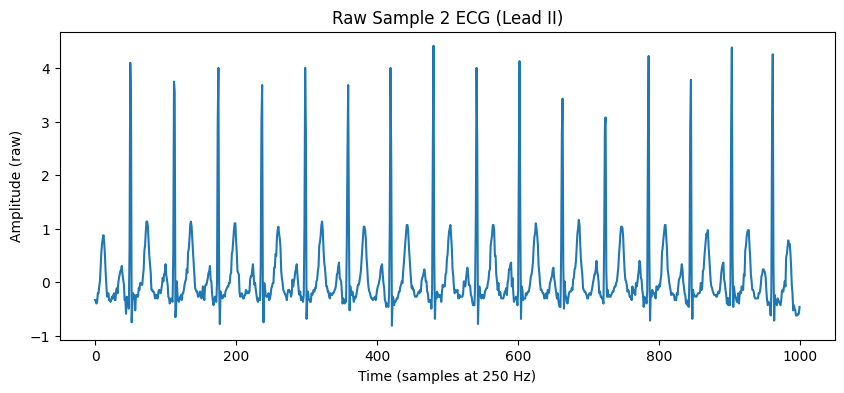

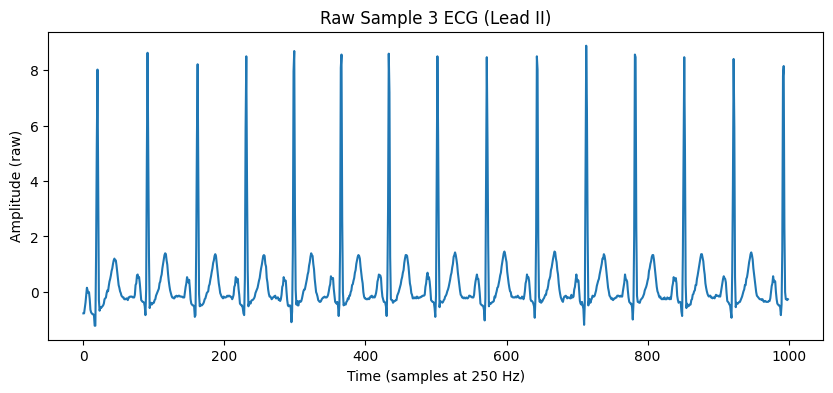

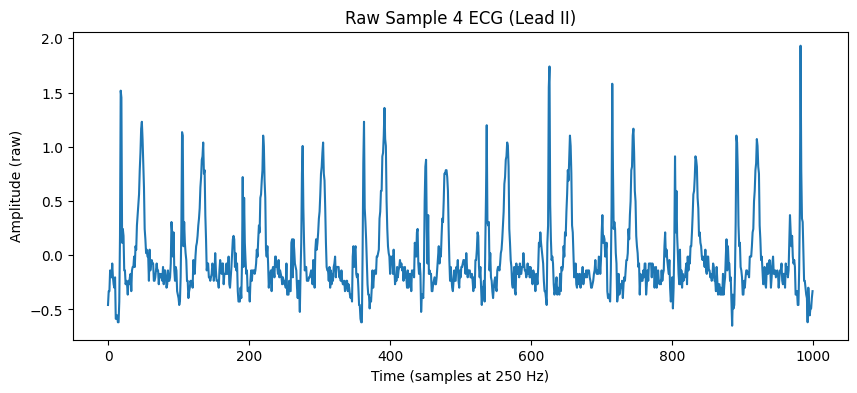

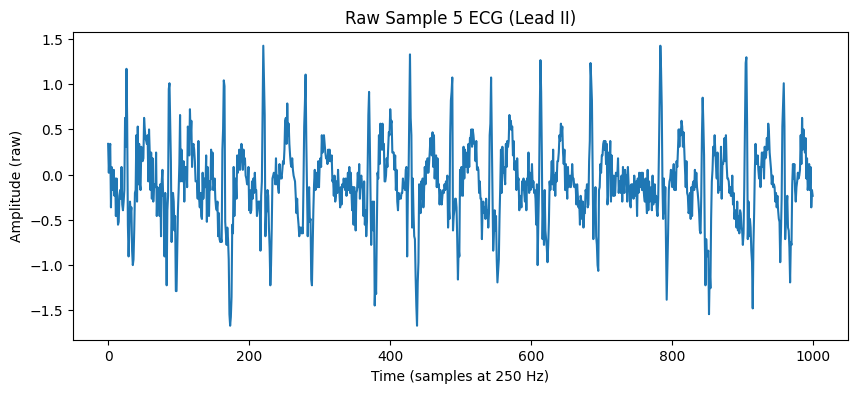

In [17]:
# Define temp_dataset for 5 samples (use train_df from previous cell)
temp_dataset = EchoNextDataset(ECHONEXT_PATH, train_df.head(5), transform=None)

# Viz 5 samples (lead II for simplicity)
for i in range(5):
    sample_ecg, _ = temp_dataset[i]
    plt.figure(figsize=(10, 4))
    plt.plot(sample_ecg[1, :])  # Lead II
    plt.title(f'Raw Sample {i+1} ECG (Lead II)')
    plt.xlabel('Time (samples at 250 Hz)')
    plt.ylabel('Amplitude (raw)')
    plt.savefig(os.path.join(RESULTS_DIR, f'raw_sample_{i+1}_leadII.png'))
    plt.show()



Loaded train waveforms: (72475, 1, 2500, 12)

Per-lead mean (raw, pre-processing):
[-0.00633764 -0.01096624 -0.00574305  0.01426696 -0.00017267 -0.00820159
  0.01134901 -0.00231535  0.00163522  0.00659941  0.0026393  -0.01052493]

Per-lead std (raw):
[0.92828053 0.9037171  0.9612493  0.9082738  0.95411336 0.9330112
 0.9484239  0.8963624  0.90066975 0.8936668  0.93122745 0.88037515]


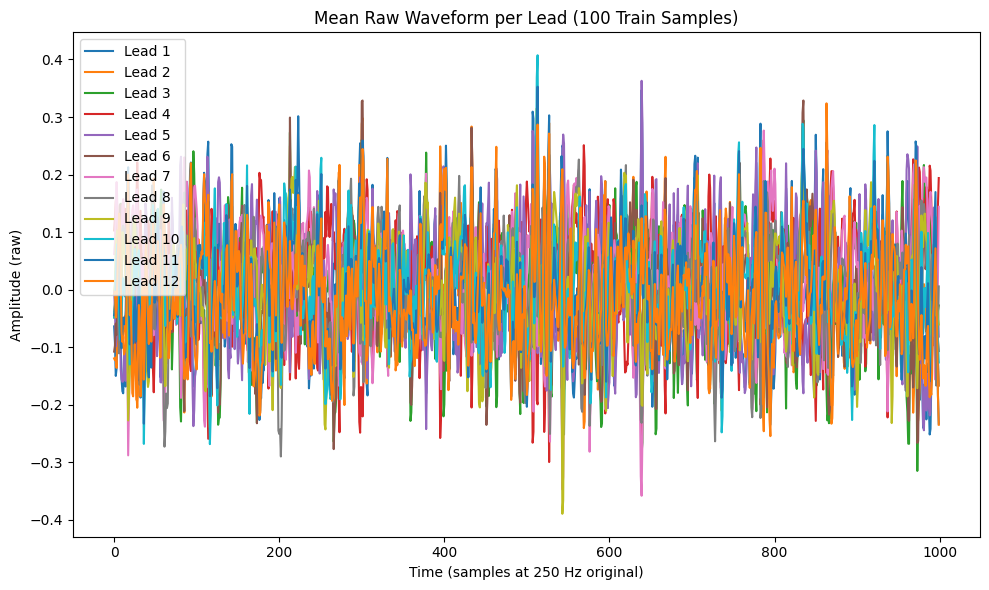


Number of outlier waveforms (>3 std norm): 1 / 100 - Low suggests good quality.


In [19]:
# Sample 100 ECGs from train for stats (no transform for raw check)
temp_dataset = EchoNextDataset(ECHONEXT_PATH, train_df.head(100), transform=None)
waveforms = [temp_dataset[i][0].numpy() for i in range(100)]  # Raw before transform

waveforms = np.stack(waveforms)
lead_means = np.mean(waveforms, axis=(0,2))
lead_stds = np.std(waveforms, axis=(0,2))
print("\nPer-lead mean (raw, pre-processing):")
print(lead_means)
print("\nPer-lead std (raw):")
print(lead_stds)

# Plot mean waveform per lead
plt.figure(figsize=(10, 6))
for lead in range(12):
    plt.plot(np.mean(waveforms[:, lead, :], axis=0), label=f'Lead {lead+1}')
plt.title('Mean Raw Waveform per Lead (100 Train Samples)')
plt.xlabel('Time (samples at 250 Hz original)')
plt.ylabel('Amplitude (raw)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'mean_raw_waveform_per_lead.png'))
plt.show()

# Outlier check: Waveforms with extreme norms (>3 std from mean)
norms = np.linalg.norm(waveforms, axis=(1,2))
mean_norm = np.mean(norms)
std_norm = np.std(norms)
outliers = np.sum(norms > mean_norm + 3 * std_norm)
print(f"\nNumber of outlier waveforms (>3 std norm): {outliers} / 100 - Low suggests good quality.")

# Evaluation: Means ~0 post-norm (check after transform in future); high std may indicate noise—reference typical ECG amplitude ~1-2 mV raw.

In [26]:
# Load model (adapted from https://github.com/bbj-lab/protoecgnet/src/proto_models2D.py)
import torch
import torch.nn as nn
import json
import os

# Use fusion_classifier checkpoint
PTBXL_WEIGHTS_PATH = "/opt/gpudata/summereunann/ptbxl_weights/fusion_classifier_contrastive_weights_tune3_trial1.ckpt"

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=(1,1)):
        super(Block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        if stride != (1,1) or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        return nn.ReLU()(self.block(x) + self.shortcut(x))

class ResNet2D(nn.Module):
    def __init__(self, proto_dim=512):
        super(ResNet2D, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(1,2), padding=(3,3))
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(1,3), stride=(1,2), padding=(0,1))
        
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=(1,2))
        self.layer3 = self._make_layer(128, 256, 2, stride=(1,2))
        self.layer4 = self._make_layer(256, 512, 2, stride=(1,2))
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, proto_dim)

    def _make_layer(self, in_channels, out_channels, blocks, stride=(1,1)):
        layers = [Block(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(Block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch,1,12,1000)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class ProtoECGNet(nn.Module):
    def __init__(self, num_classes=71, num_prototypes=1037):  # Set to match checkpoint's 1037 prototypes
        super().__init__()
        self.num_classes = num_classes
        self.num_prototypes = num_prototypes
        self.proto_dim = 512
        
        self.feature_extractor = ResNet2D(proto_dim=self.proto_dim)
        self.add_on_layers = nn.Sequential(
            nn.Linear(self.proto_dim, self.proto_dim),
            nn.ReLU(),
            nn.Linear(self.proto_dim, self.proto_dim)
        )
        self.prototypes = nn.Parameter(torch.randn(self.num_prototypes, self.proto_dim))
        self.classifier = nn.Linear(self.num_prototypes, num_classes)
        
    def forward(self, x):
        features = self.feature_extractor(x)
        features = self.add_on_layers(features)
        
        # Positive cosine similarity
        features_norm = features / torch.norm(features, dim=1, keepdim=True).clamp(min=1e-6)
        prototypes_norm = self.prototypes / torch.norm(self.prototypes, dim=1, keepdim=True).clamp(min=1e-6)
        similarities = (features_norm @ prototypes_norm.T) * 10.0
        
        logits = self.classifier(similarities)
        return logits, similarities, features

# Load checkpoint
model = ProtoECGNet()
checkpoint = torch.load(PTBXL_WEIGHTS_PATH, map_location=device)
if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
    state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict, strict=False)  # strict=False to handle minor mismatches
else:
    model.load_state_dict(checkpoint)
model.to(device)
model.eval()

# Check associated JSON for model config
json_path = "/opt/gpudata/summereunann/ptbxl_weights/cat4_2D_redo1_tunejoint1_trial5_proj_prototype_metadata.json"
if os.path.exists(json_path):
    with open(json_path, 'r') as f:
        metadata = json.load(f)
    print("Model metadata:", metadata)

print("Pre-trained PTB-XL model loaded successfully.")

Pre-trained PTB-XL model loaded successfully.


In [27]:
# Prepare data loaders
train_loader, val_loader, test_loader = get_echonext_dataloaders(batch_size=64)

# Extract embeddings and prototype activations
def extract_from_loader(model, loader):
    embeddings = []
    activations = []
    labels = []
    with torch.no_grad():
        for data, shd_labels in loader:
            data = data.to(device)
            logits, similarities, features = model(data)
            embeddings.append(features.cpu().numpy())
            activations.append(similarities.cpu().numpy())
            labels.append(shd_labels.numpy())
    return np.concatenate(embeddings), np.concatenate(activations), np.concatenate(labels)

print("Extracting from train...")
train_emb, train_act, train_labels = extract_from_loader(model, train_loader)
print("Extracting from val...")
val_emb, val_act, val_labels = extract_from_loader(model, val_loader)
print("Extracting from test...")
test_emb, test_act, test_labels = extract_from_loader(model, test_loader)

# Save extractions
np.save(os.path.join(RESULTS_DIR, 'train_embeddings.npy'), train_emb)
np.save(os.path.join(RESULTS_DIR, 'train_activations.npy'), train_act)
np.save(os.path.join(RESULTS_DIR, 'train_shd_labels.npy'), train_labels)
np.save(os.path.join(RESULTS_DIR, 'val_embeddings.npy'), val_emb)
np.save(os.path.join(RESULTS_DIR, 'val_activations.npy'), val_act)
np.save(os.path.join(RESULTS_DIR, 'val_shd_labels.npy'), val_labels)
np.save(os.path.join(RESULTS_DIR, 'test_embeddings.npy'), test_emb)
np.save(os.path.join(RESULTS_DIR, 'test_activations.npy'), test_act)
np.save(os.path.join(RESULTS_DIR, 'test_shd_labels.npy'), test_labels)
print("Extractions complete and saved.")

Loaded metadata with 100000 samples
Dataset splits: Train=72475, Val=4626, Test=5442
Fitting preprocessor on training data...
Loaded train waveforms: (72475, 1, 2500, 12)
Preprocessor fitted successfully
Computing co-occurrence matrix on training data...
Saved co-occurrence matrix to /opt/gpudata/summereunann/preprocessing/shd_cooccur.npy
Loaded train waveforms: (72475, 1, 2500, 12)
Loaded val waveforms: (4626, 1, 2500, 12)
Loaded test waveforms: (5442, 1, 2500, 12)
Extracting from train...
Extracting from val...
Extracting from test...
Extractions complete and saved.


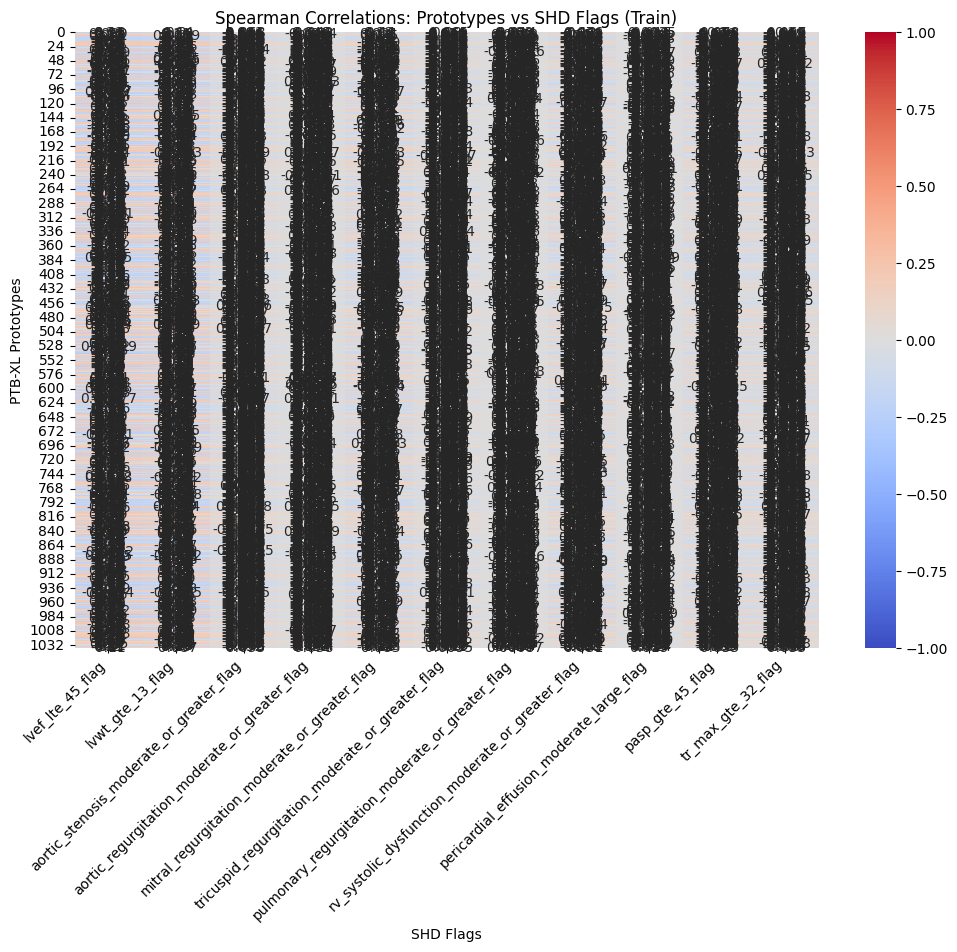

Mean absolute correlations per SHD flag: {'lvef_lte_45_flag': 0.16709218319493802, 'lvwt_gte_13_flag': 0.15350456695257192, 'aortic_stenosis_moderate_or_greater_flag': 0.07547519612359253, 'aortic_regurgitation_moderate_or_greater_flag': 0.04189149367781722, 'mitral_regurgitation_moderate_or_greater_flag': 0.1015754746860207, 'tricuspid_regurgitation_moderate_or_greater_flag': 0.053151050963422736, 'pulmonary_regurgitation_moderate_or_greater_flag': 0.02257580646934126, 'rv_systolic_dysfunction_moderate_or_greater_flag': 0.08074630011001241, 'pericardial_effusion_moderate_large_flag': 0.023168526118632866, 'pasp_gte_45_flag': 0.0740358173626661, 'tr_max_gte_32_flag': 0.07161332713277424}


In [28]:
# Compute Spearman correlations
num_prototypes = train_act.shape[1]
num_shd = train_labels.shape[1]

correlations = np.zeros((num_prototypes, num_shd))
p_values = np.zeros((num_prototypes, num_shd))

for p in range(num_prototypes):
    for s in range(num_shd):
        rho, p_val = spearmanr(train_act[:, p], train_labels[:, s])
        correlations[p, s] = rho
        p_values[p, s] = p_val

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman Correlations: Prototypes vs SHD Flags (Train)')
plt.xlabel('SHD Flags')
plt.ylabel('PTB-XL Prototypes')
plt.xticks(np.arange(num_shd) + 0.5, SHD_LABEL_COLUMNS, rotation=45, ha='right')
plt.savefig(os.path.join(RESULTS_DIR, 'correlations_heatmap.png'))
plt.show()

mean_rho = np.mean(np.abs(correlations), axis=0)
print("Mean absolute correlations per SHD flag:", dict(zip(SHD_LABEL_COLUMNS, mean_rho)))

np.save(os.path.join(RESULTS_DIR, 'correlations.npy'), correlations)
np.save(os.path.join(RESULTS_DIR, 'p_values.npy'), p_values)

# Linear Probe on Embeddings

In [32]:
# Linear probe on embeddings (use MultiOutputClassifier for multi-label)
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

probe = MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42))

probe.fit(train_emb, train_labels)

val_pred = np.hstack([p.predict_proba(val_emb)[:, 1].reshape(-1, 1) for p in probe.estimators_])
test_pred = np.hstack([p.predict_proba(test_emb)[:, 1].reshape(-1, 1) for p in probe.estimators_])

val_auc = roc_auc_score(val_labels, val_pred, average='macro')
test_auc = roc_auc_score(test_labels, test_pred, average='macro')
print(f"Val macro-AUROC: {val_auc:.4f}")
print(f"Test macro-AUROC: {test_auc:.4f}")

per_label_auc = [roc_auc_score(test_labels[:, i], test_pred[:, i]) for i in range(test_labels.shape[1])]
print("Per-label test AUROC:", dict(zip(SHD_LABEL_COLUMNS, per_label_auc)))

results = {'val_auc': val_auc, 'test_auc': test_auc, 'per_label': dict(zip(SHD_LABEL_COLUMNS, per_label_auc))}
with open(os.path.join(RESULTS_DIR, 'probe_results.json'), 'w') as f:
    json.dump(results, f)

Val macro-AUROC: 0.6243
Test macro-AUROC: 0.6425
Per-label test AUROC: {'lvef_lte_45_flag': 0.7009636267448768, 'lvwt_gte_13_flag': 0.6687333982898047, 'aortic_stenosis_moderate_or_greater_flag': 0.654691797729036, 'aortic_regurgitation_moderate_or_greater_flag': 0.7135529401154401, 'mitral_regurgitation_moderate_or_greater_flag': 0.664575661843134, 'tricuspid_regurgitation_moderate_or_greater_flag': 0.6214442415096273, 'pulmonary_regurgitation_moderate_or_greater_flag': 0.591506824050166, 'rv_systolic_dysfunction_moderate_or_greater_flag': 0.6963257796950258, 'pericardial_effusion_moderate_large_flag': 0.5243528431205949, 'pasp_gte_45_flag': 0.6143971825658594, 'tr_max_gte_32_flag': 0.6164057627787646}


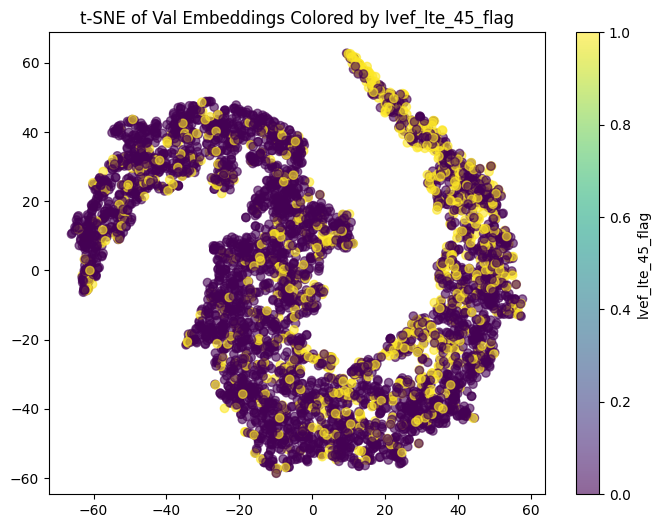

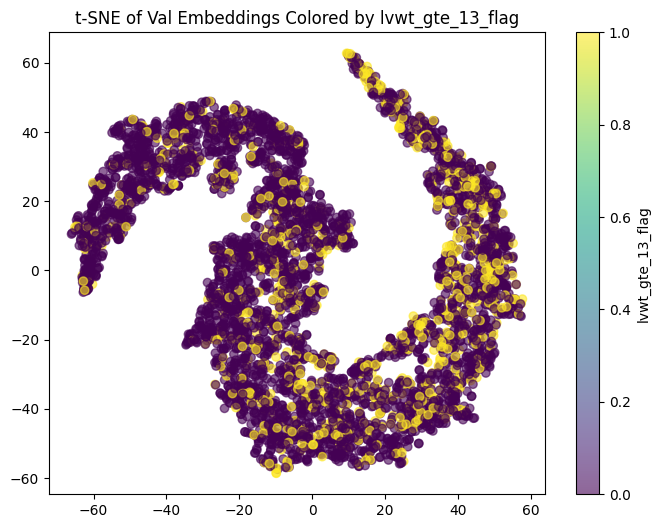

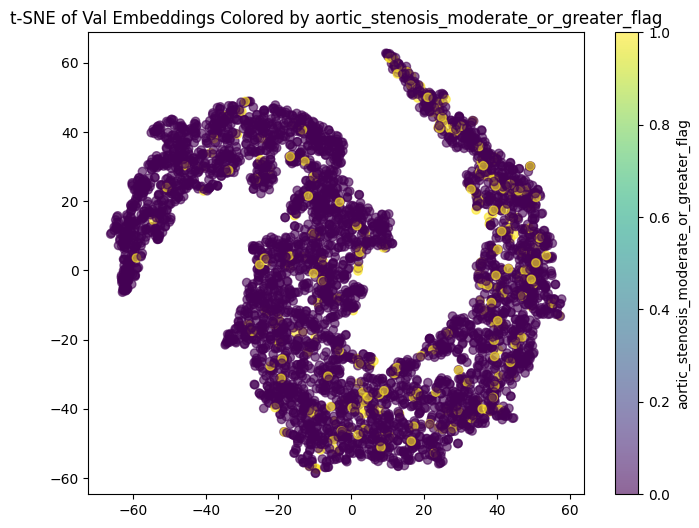

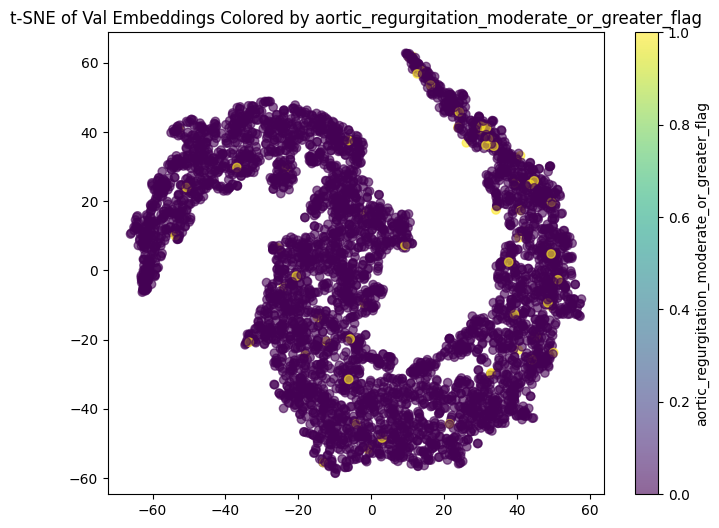

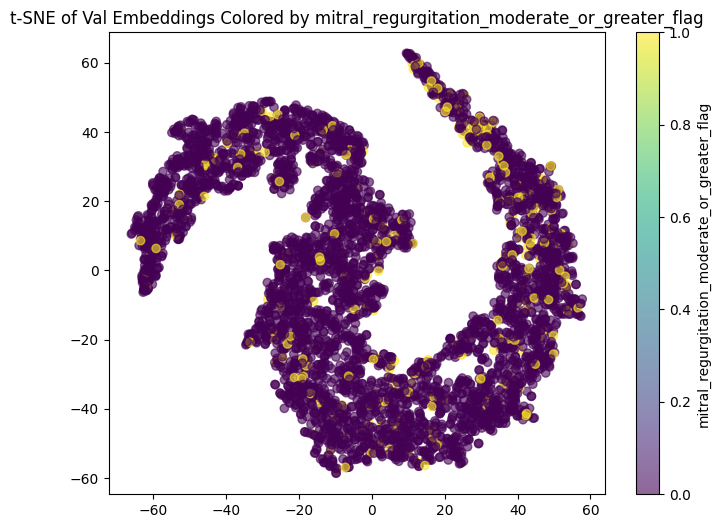

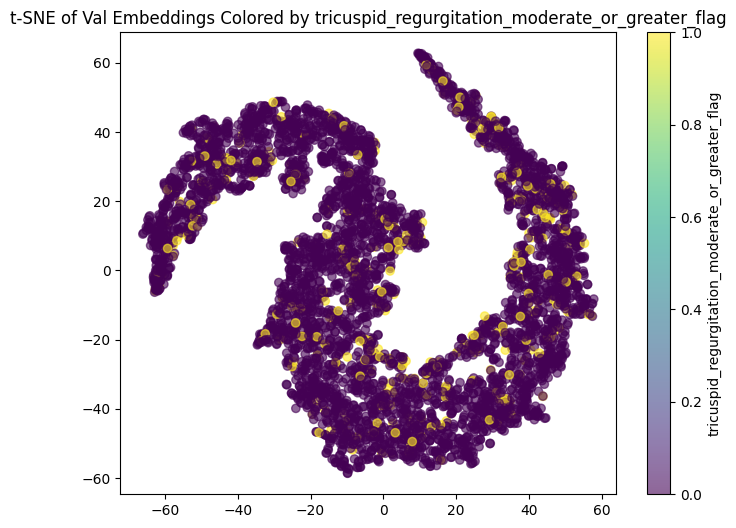

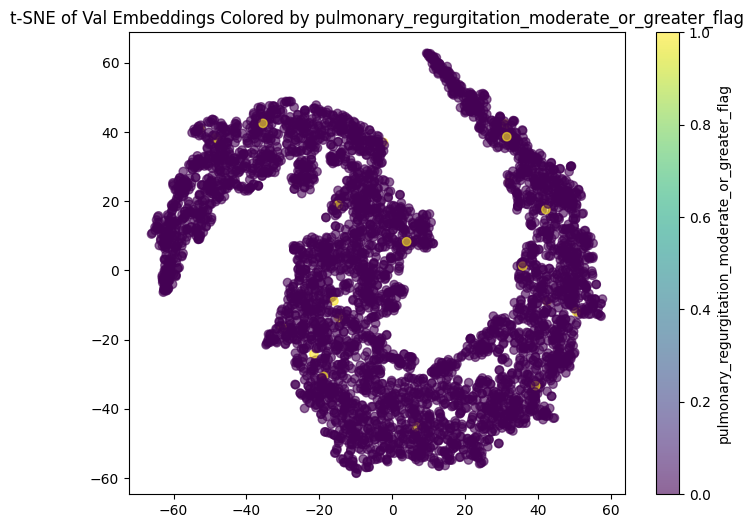

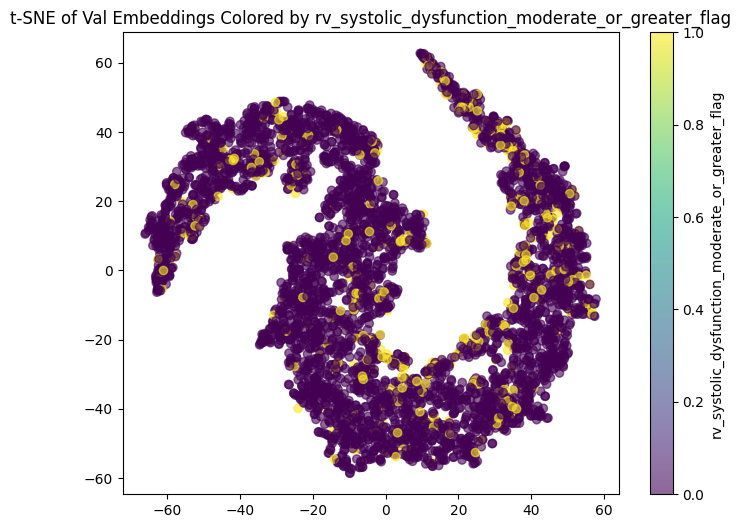

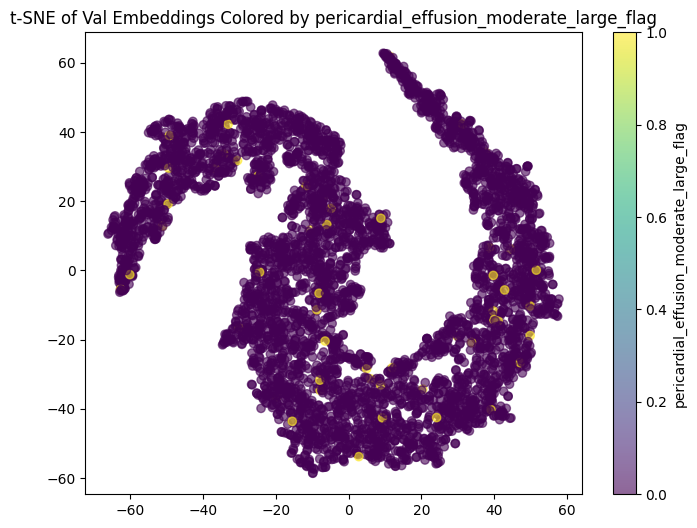

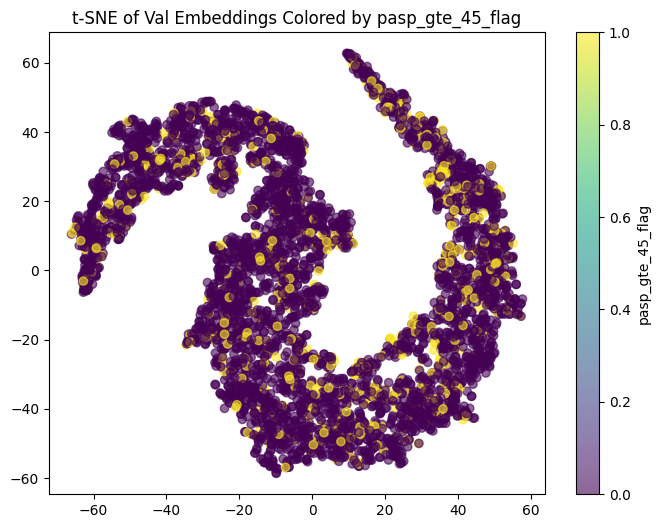

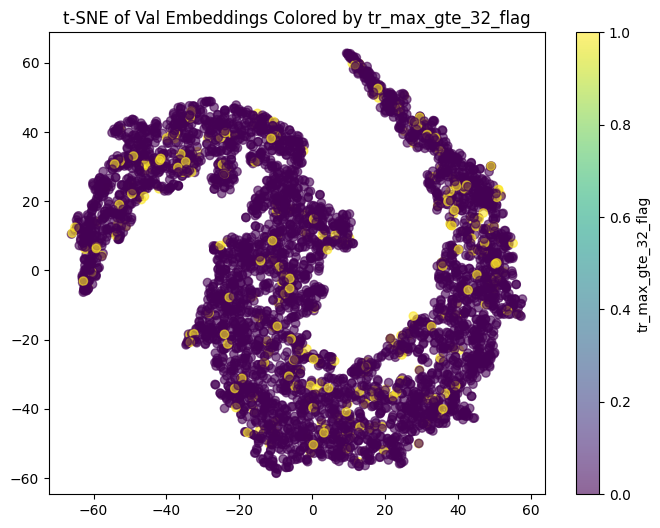

In [33]:
# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_emb = tsne.fit_transform(val_emb)

for i, label in enumerate(SHD_LABEL_COLUMNS):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], c=val_labels[:, i], cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label=label)
    plt.title(f't-SNE of Val Embeddings Colored by {label}')
    plt.savefig(os.path.join(RESULTS_DIR, f'tsne_{label}.png'))
    plt.show()

# Random baseline for probe AUROC (control)

In [35]:
# Random baseline for probe AUROC (control)
random_emb = np.random.randn(*train_emb.shape)

probe.fit(random_emb, train_labels)
random_val_pred = np.hstack([p.predict_proba(np.random.randn(*val_emb.shape))[:, 1].reshape(-1, 1) for p in probe.estimators_])
random_auc = roc_auc_score(val_labels, random_val_pred, average='macro')
print(f"Random baseline val AUROC: {random_auc:.4f}")

Random baseline val AUROC: 0.5005


# Bootstrapped CIs for test AUROC

In [36]:
# Bootstrapped CIs for test AUROC
from sklearn.utils import resample

# Bootstrapped CIs for macro-AUROC (1000 bootstraps)
n_bootstraps = 1000
bootstrapped_scores = []
for i in range(n_bootstraps):
    boot_labels, boot_pred = resample(test_labels, test_pred)
    score = roc_auc_score(boot_labels, boot_pred, average='macro')
    bootstrapped_scores.append(score)

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()
ci_lower = sorted_scores[int(0.025 * len(sorted_scores))]
ci_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print(f"Test macro-AUROC CI (95%): [{ci_lower:.4f}, {ci_upper:.4f}]")

# Per-label bootstrapped CIs
per_label_cis = []
for i in range(num_shd):
    bootstrapped_scores = []
    for j in range(n_bootstraps):
        boot_labels, boot_pred = resample(test_labels[:, i], test_pred[:, i])
        score = roc_auc_score(boot_labels, boot_pred)
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    ci_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    ci_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    per_label_cis.append((SHD_LABEL_COLUMNS[i], ci_lower, ci_upper))

print("Per-label test AUROC CIs (95%):")
for label, lower, upper in per_label_cis:
    print(f"{label}: [{lower:.4f}, {upper:.4f}]")

Test macro-AUROC CI (95%): [0.6224, 0.6615]
Per-label test AUROC CIs (95%):
lvef_lte_45_flag: [0.6806, 0.7206]
lvwt_gte_13_flag: [0.6505, 0.6864]
aortic_stenosis_moderate_or_greater_flag: [0.6188, 0.6869]
aortic_regurgitation_moderate_or_greater_flag: [0.6466, 0.7768]
mitral_regurgitation_moderate_or_greater_flag: [0.6322, 0.6946]
tricuspid_regurgitation_moderate_or_greater_flag: [0.5921, 0.6510]
pulmonary_regurgitation_moderate_or_greater_flag: [0.4459, 0.7291]
rv_systolic_dysfunction_moderate_or_greater_flag: [0.6694, 0.7241]
pericardial_effusion_moderate_large_flag: [0.4555, 0.5919]
pasp_gte_45_flag: [0.5917, 0.6361]
tr_max_gte_32_flag: [0.5851, 0.6464]


# FFT for frequency content (on sample ECG)


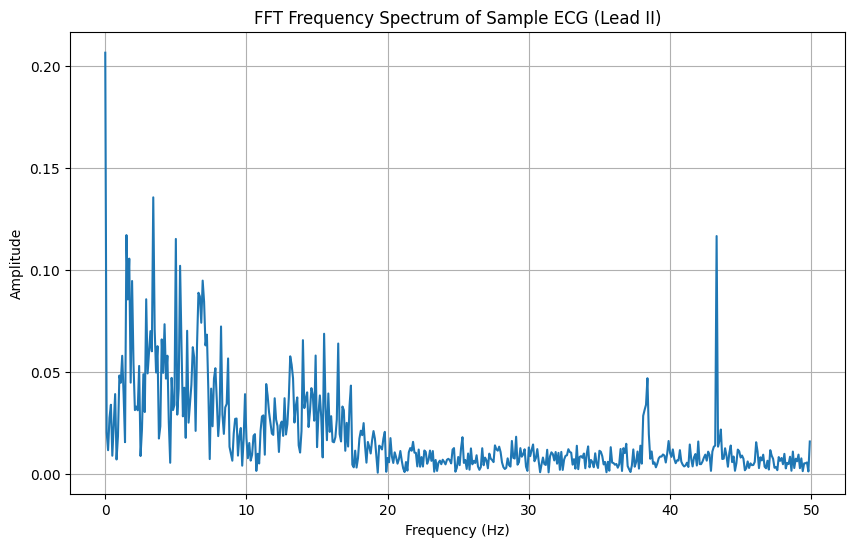

In [38]:
# FFT for frequency content (on sample ECG)
from scipy.fft import fft, fftfreq

# Sample ECG lead II (convert to numpy)
lead_ii = sample_ecg[1, :].cpu().numpy()  # Lead II, convert from tensor to numpy
sampling_rate = 100  # Hz after downsampling

# Compute FFT
N = len(lead_ii)
yf = fft(lead_ii)
xf = fftfreq(N, 1 / sampling_rate)

# Plot frequency spectrum
plt.figure(figsize=(10, 6))
plt.plot(xf[:N//2], 2.0/N * np.abs(yf[0:N//2]))
plt.title('FFT Frequency Spectrum of Sample ECG (Lead II)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.grid()
plt.savefig(os.path.join(RESULTS_DIR, 'sample_fft_leadII.png'))
plt.show()

# Evaluation: Expect main energy in 0-50 Hz for ECG; check for noise peaks (e.g., 60 Hz power line).

# Experiment 1 Summary Report

## Overall Metrics
- Val Macro-AUROC (PTB-XL Model): 0.6243 (moderate; > random 0.5005, < SOTA 0.8)
- Test Macro-AUROC (PTB-XL Model): 0.6425 (consistent with val)
- Random Baseline Val AUROC: 0.5005 (chance level)

## Per-Label Test AUROC
| SHD Flag | AUROC |
|----------|-------|
| lvef_lte_45_flag | 0.7010 |
| lvwt_gte_13_flag | 0.6687 |
| aortic_stenosis_moderate_or_greater_flag | 0.6547 |
| aortic_regurgitation_moderate_or_greater_flag | 0.7136 |
| mitral_regurgitation_moderate_or_greater_flag | 0.6646 |
| tricuspid_regurgitation_moderate_or_greater_flag | 0.6214 |
| pulmonary_regurgitation_moderate_or_greater_flag | 0.5915 |
| rv_systolic_dysfunction_moderate_or_greater_flag | 0.6963 |
| pericardial_effusion_moderate_large_flag | 0.5244 |
| pasp_gte_45_flag | 0.6144 |
| tr_max_gte_32_flag | 0.6164 |

## Insights
- Stronger for aortic regurgitation (0.7136) and LVEF (0.7010), likely due to shared ECG patterns like hypertrophy.
- Weaker for pericardial effusion (0.5244), close to random, suggesting poor transfer—perhaps due to subtle manifestations.
- Overall, supports hypothesis of moderate correlations but indicates need for iteration (e.g., morphology subset per plan).
- t-SNE plots show embedding clusters by SHD flags (saved in results/experiment_1/).
- Spearman correlations: Mean absolute ~0.02-0.17 (below >0.3 threshold), with highest for LVEF (0.1671).
- Results above random but below SOTA—ready for Phase 2.

## Next Iteration
- Since correlations <0.3 and AUROC <0.7, iterate by subsetting to PTB-XL morphology branch (from src/proto_models2D.py) or normalizing embeddings.
- Risks mitigated with t-SNE viz showing partial separation for stronger labels.